<a href="https://colab.research.google.com/github/jqwhite/PhysBioCell/blob/main/1_2_bacterial_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image analysis of colony growth 

© 2022 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). This work has been modified for use in Google Colaboratory.

***

In this notebook we are going to use microscopy data of bacteria to determine their growth rate. In order to do that, we took images of the same colony over a period of about 1-2 hours. What we need to do is to take the images, segment out the pixels that correspond to bacteria, and measure how the area of the bacteria is chaning over time.  We will then fit the area to an exponential curve to determine the growth rate of our bacteria.

In [125]:
# Import packages for requesting image data from the server
import requests
import zipfile

# To find files
import glob

r=requests.get('http://rpdata.caltech.edu/courses/course_data/ecoli_growth.zip')

filename = "growth_data.zip"
with open(filename, mode="wb") as localfile:
  localfile.write(r.content)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('.')

Now that we have the data, we can proceed with the analysis.

In [126]:
# For numerical computation
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For cool interactive stuff
import panel as pn

# For image analysis
import skimage.io
import skimage.filters

# This enables high resolution graphics inline
%config InlineBackend.figure_format = 'retina'
pn.extension()
sns.set()

Let's look at a list of the image files.

In [127]:
files = glob.glob('./ecoli_growth/*TRITC*')
files[0:5]

['./ecoli_growth/ecoli_TRITC_14.tif',
 './ecoli_growth/ecoli_TRITC_04.tif',
 './ecoli_growth/ecoli_TRITC_06.tif',
 './ecoli_growth/ecoli_TRITC_08.tif',
 './ecoli_growth/ecoli_TRITC_01.tif']

In [128]:
im = skimage.io.imread(files[0])
im

array([[204, 206, 205, ..., 204, 204, 204],
       [204, 206, 204, ..., 204, 204, 204],
       [205, 205, 204, ..., 204, 205, 205],
       ...,
       [204, 204, 205, ..., 203, 204, 204],
       [204, 204, 204, ..., 203, 204, 204],
       [206, 205, 205, ..., 203, 203, 204]], dtype=uint16)

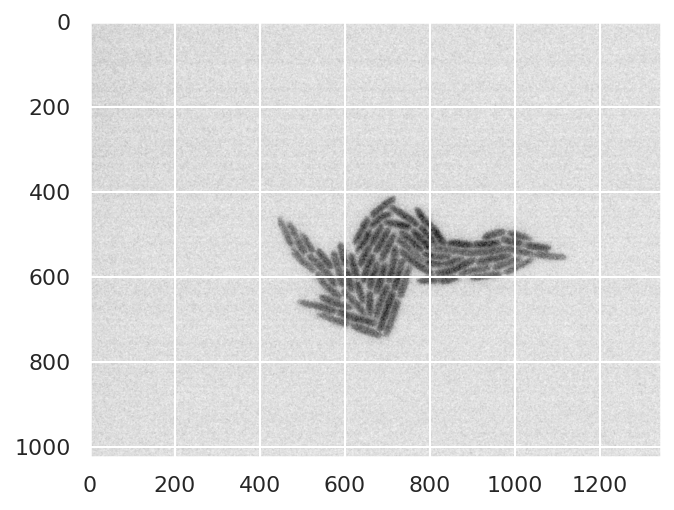

In [129]:
plt.imshow(im, cmap=plt.cm.Greys);

In [130]:
def plot_image(im):
  fig,ax = plt.subplots()
  ax.imshow(im,cmap=plt.cm.Greys)
  ax.grid(False)

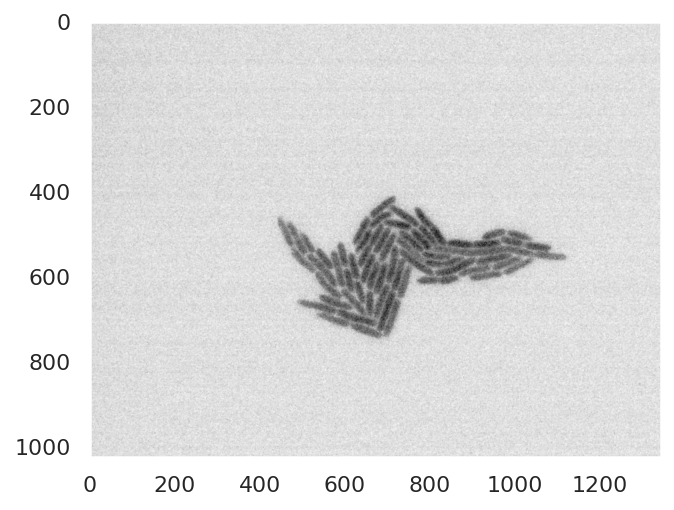

In [131]:
plot_image(im)

In [132]:
np.max(im)

218

In [133]:
np.min(im)

200

In [134]:
# dynamic range is small
# normalize by range
im_norm = (im-np.min(im)) / (np.max(im) - np.min(im))

In [135]:
np.min(im_norm)

0.0

In [136]:
np.max(im_norm)

1.0

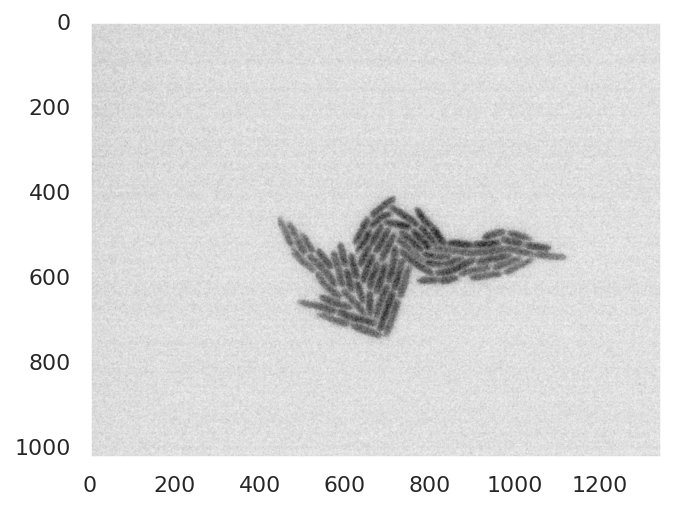

In [137]:
# normalized plot looks the same because colormap is normalized
plot_image(im_norm)

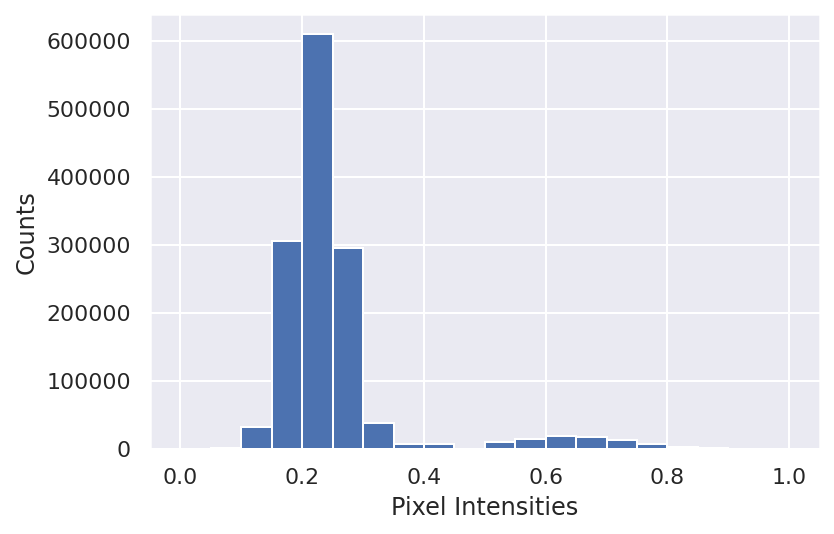

In [138]:
plt.hist(im_norm.flatten(), bins=20);
plt.xlabel("Pixel Intensities")
plt.ylabel("Counts");

In [139]:
threshold = skimage.filters.threshold_minimum(im_norm)

In [140]:
im_thresh = np.where((im_norm < threshold), 0,1)

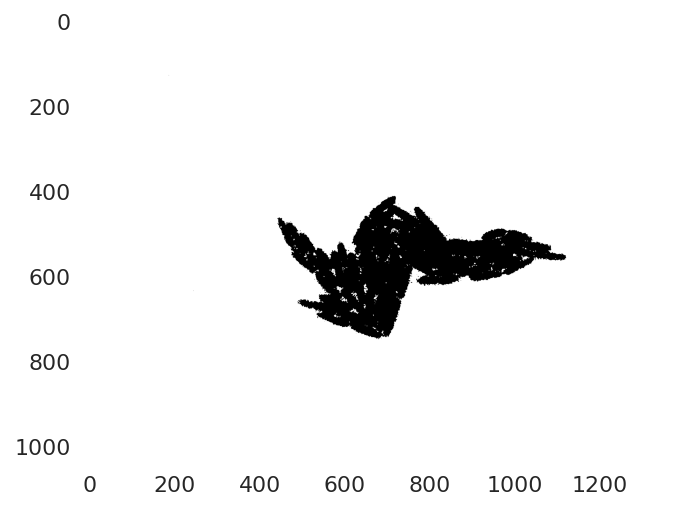

In [141]:
plot_image(im_thresh)

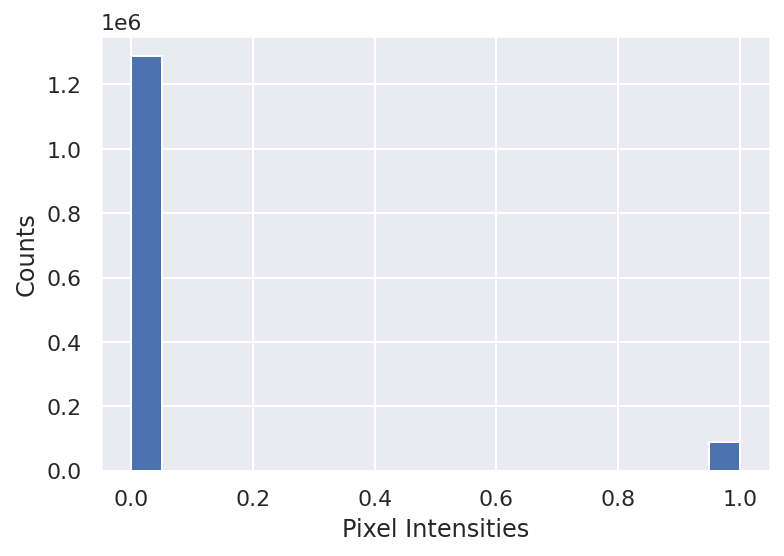

In [142]:
plt.hist(im_thresh.flatten(), bins=20);
plt.xlabel("Pixel Intensities")
plt.ylabel("Counts");

In [143]:
area = np.sum(im_thresh)
area

89105

In [144]:
sorted_files = np.sort(files)
sorted_files[0:10]

array(['./ecoli_growth/ecoli_TRITC_00.tif',
       './ecoli_growth/ecoli_TRITC_01.tif',
       './ecoli_growth/ecoli_TRITC_02.tif',
       './ecoli_growth/ecoli_TRITC_03.tif',
       './ecoli_growth/ecoli_TRITC_04.tif',
       './ecoli_growth/ecoli_TRITC_05.tif',
       './ecoli_growth/ecoli_TRITC_06.tif',
       './ecoli_growth/ecoli_TRITC_07.tif',
       './ecoli_growth/ecoli_TRITC_08.tif',
       './ecoli_growth/ecoli_TRITC_09.tif'], dtype='<U33')

In [145]:
def process_image_file(image_file):

  im        = skimage.io.imread(image_file)
  im_norm   = (im-np.min(im)) / (np.max(im) - np.min(im))
  threshold = skimage.filters.threshold_minimum(im_norm)
  im_thresh = np.where((im_norm < threshold), 0,1)
  # plot_image(im_thresh)
  area      = np.sum(im_thresh)

  return area


In [146]:
growth = [process_image_file(file) for file in sorted_files]
growth

[8832,
 10141,
 11725,
 14680,
 17128,
 20596,
 24378,
 28562,
 33478,
 37599,
 44221,
 53241,
 63377,
 77504,
 89105,
 106619,
 124797,
 148534,
 170191,
 203670,
 237997]

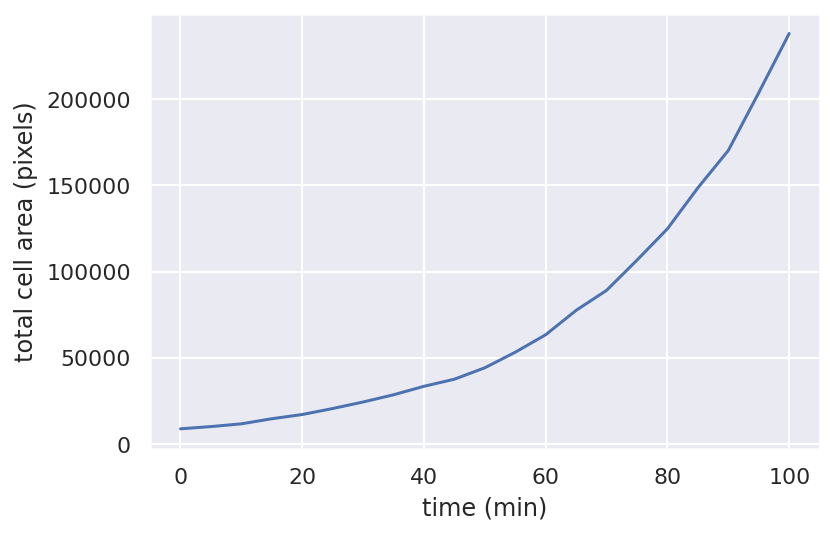

In [147]:
x = np.arange(len(files))*dt
y = growth
plt.plot(x,  y)
# plt.yscale('log')
plt.xlabel("time (min)")
plt.ylabel("total cell area (pixels)");

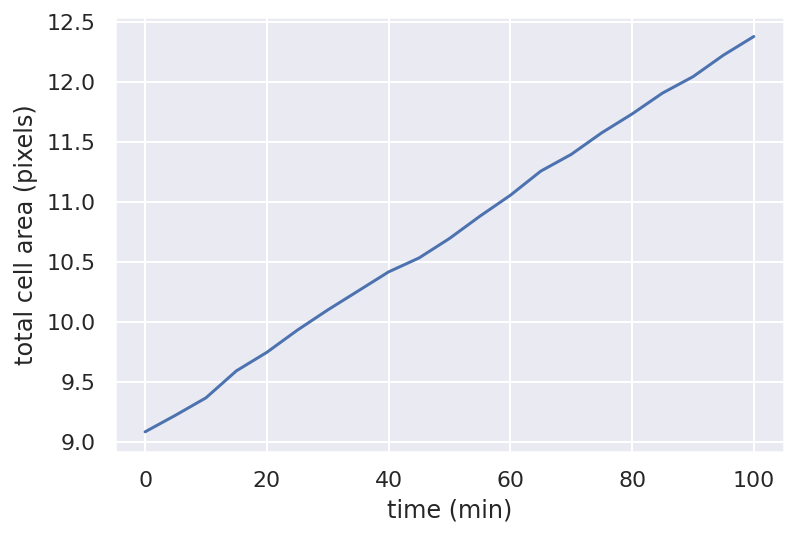

In [148]:
growth_ln = [np.log(g) for g in growth]
x = np.arange(len(files))*dt
y = growth_ln
plt.plot(x,  y)
# plt.yscale('log')
plt.xlabel("time (min)")
plt.ylabel("total cell area (pixels)");

In [149]:
def err(areas, times, growth_rate):

  '''
  Computes error between data and theory

  Parameters
  ----------
  areas : array-like
    Experimental values of colony areas

  times : array-like
    Times at which measurements were taken

  growth_rate : float
    growth rate

  Returns
  -------
  r_squared : Numpy array
    Squared error between theory and experiment

  '''
  area_theory = areas[0]*np.exp(growth_rate*times)
  r_squared = np.sum((areas - area_theory)**2)
  return r_squared

In [150]:
k_arr = np.linspace(0.02, 0.05, 200)
# k_arr

In [161]:
residuals = np.zeros(len(k_arr))
# residuals = [err(a, t, k) for a,t,k in k_arr]
for i,k in enumerate(k_arr):
  residuals[i] = err(growth,time_points, k)

In [160]:
residuals

array([9.33305819e+10, 9.21846164e+10, 9.10304505e+10, 8.98681634e+10,
       8.86978411e+10, 8.75195758e+10, 8.63334667e+10, 8.51396203e+10,
       8.39381503e+10, 8.27291781e+10, 8.15128329e+10, 8.02892525e+10,
       7.90585827e+10, 7.78209785e+10, 7.65766038e+10, 7.53256322e+10,
       7.40682469e+10, 7.28046413e+10, 7.15350192e+10, 7.02595954e+10,
       6.89785960e+10, 6.76922584e+10, 6.64008324e+10, 6.51045801e+10,
       6.38037764e+10, 6.24987096e+10, 6.11896818e+10, 5.98770093e+10,
       5.85610231e+10, 5.72420695e+10, 5.59205105e+10, 5.45967244e+10,
       5.32711062e+10, 5.19440683e+10, 5.06160413e+10, 4.92874741e+10,
       4.79588347e+10, 4.66306113e+10, 4.53033122e+10, 4.39774669e+10,
       4.26536269e+10, 4.13323661e+10, 4.00142817e+10, 3.86999950e+10,
       3.73901521e+10, 3.60854249e+10, 3.47865115e+10, 3.34941375e+10,
       3.22090567e+10, 3.09320520e+10, 2.96639365e+10, 2.84055542e+10,
       2.71577811e+10, 2.59215263e+10, 2.46977332e+10, 2.34873802e+10,
      

In [152]:
time_points

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])

In [153]:
err(growth, time_points, k)

2722851032436.246

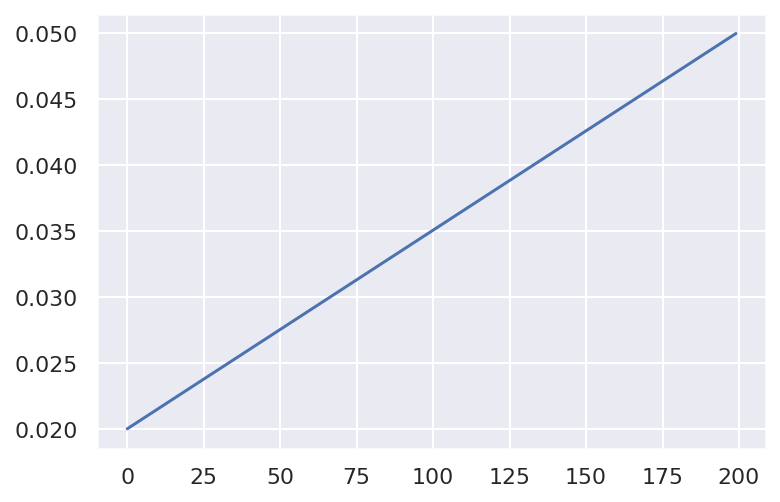

In [154]:
plt.plot(k_arr);

In [155]:
k_ind = np.argmin(residuals)
round(k_arr[k_ind],3)
k_opt = k_arr[k_ind]

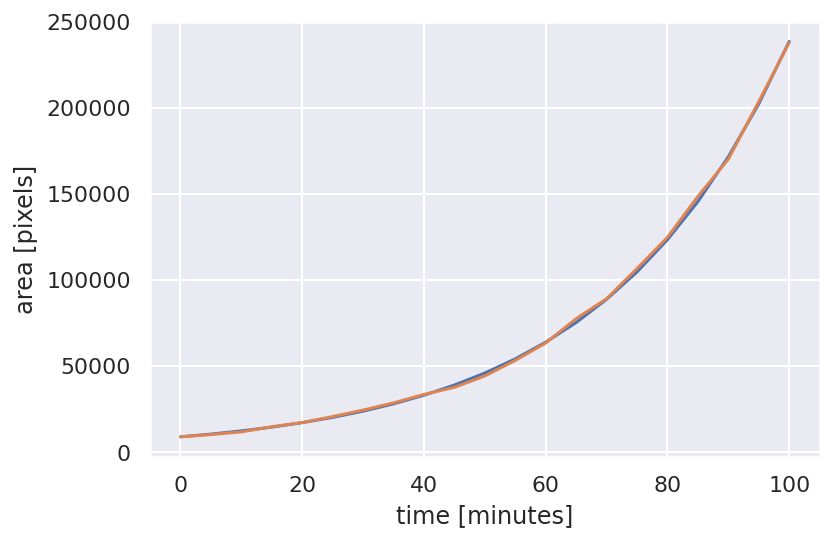

In [156]:
best_fit = growth[0]*np.exp(k_opt*time_points)
plt.plot(time_points, best_fit, label="Fit")
plt.plot(time_points, growth, label="Data")
plt.xlabel('time [minutes]')
plt.ylabel('area [pixels]');